## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import scanpy as sc
# sc.set_figure_params(dpi=100, dpi_save=300)
import scvi
import anndata as ad
from matplotlib import pyplot, cm
import os
from math import ceil
from scipy.stats import spearmanr
import math

import leidenalg

from anndata import AnnData
import scanpy as sc
from scanpy import read
import pandas as pd
from sciPENN.Preprocessing import preprocess

import matplotlib.pyplot as plt
print(scvi.__version__)

0.9.1


# Read data: Pbmc (train), H1N1 (test)

In [2]:
adata_gene = sc.read("../Data/pbmc/pbmc_gene.h5ad")
adata_protein = sc.read("../Data/pbmc/pbmc_protein.h5ad")

doublet_bool = (adata_gene.obs['celltype.l2'] != 'Doublet')

adata_gene = adata_gene[doublet_bool].copy()
adata_protein = adata_protein[doublet_bool].copy()

train_patients = ['P1', 'P3', 'P4', 'P7']
test_patients = np.setdiff1d(np.unique(adata_protein.obs['donor']), train_patients)

train_bools = [x in train_patients for x in adata_gene.obs['donor']]
test_bools = np.invert(train_bools)

adata_gene_test = adata_gene[test_bools].copy()
adata_protein_test = adata_protein[test_bools].copy()

adata_gene = adata_gene[train_bools].copy()
adata_protein = adata_protein[train_bools].copy()

# Selecting highly variable genes - using gene expression measures from test data 

In [4]:
gene_train, protein_train, gene_test, bools, train_keys, categories = preprocess([adata_gene], [adata_protein], adata_gene_test, train_batchkeys = ["donor"], test_batchkey = "donor", gene_list = [], select_hvg = True, cell_normalize = True, log_normalize = True, gene_normalize = True, min_cells = 30, min_genes = 200)


QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


... storing 'orig.ident' as categorical
... storing 'donor' as categorical
... storing 'batch' as categorical
... storing 'Dataset' as categorical
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



Normalizing Gene Training Data by Batch


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


In [5]:
hvg = gene_test.var_names
cells_test = gene_test.obs_names
cells_train = gene_train.obs_names

In [6]:
del gene_train
del gene_test
del protein_train

import gc
gc.collect()

4329

# Format data

In [7]:
# What proteins overlap between the test and train data?

train_protein = adata_protein.var_names
test_protein = adata_protein_test.var_names
overlap_protein = train_protein[train_protein.isin(test_protein)]

In [8]:
## Subsetting the data by the HVG - pbmc

adata_gene_pbmc_hvg = adata_gene[cells_train, hvg].copy()

In [9]:

## Subsetting the data by the HVG - h1n1

adata_gene_h1n1_hvg = adata_gene_test[cells_test, hvg].copy()

In [10]:
(adata_gene_pbmc_hvg.var.index == adata_gene_h1n1_hvg.var.index).mean()

1.0

In [11]:
adata_protein = adata_protein[cells_train, :].copy()
adata_protein_test = adata_protein_test[cells_test, :].copy()

In [12]:
# Batches (subject) in training data - pbmc (8 subjects)

adata_gene_pbmc_hvg.obs['patient'] = pd.DataFrame(adata_gene_pbmc_hvg.obs['donor']).copy()
adata_gene_pbmc_hvg.obs['patient'] = adata_gene_pbmc_hvg.obs['patient'].astype("str")

In [13]:
# Batches (subject) in test data - h1n1 (20 subjects)

adata_gene_h1n1_hvg.obs['patient'] = pd.DataFrame(adata_gene_h1n1_hvg.obs['donor']).copy()
adata_gene_h1n1_hvg.obs['patient'] = adata_gene_h1n1_hvg.obs['patient'].astype("str")

In [14]:
## Combine data

adata = ad.concat([adata_gene_pbmc_hvg.copy(), adata_gene_h1n1_hvg.copy()],
                     join='outer')

### Note: Train on PBMC

# Subset data based on HVGs and Hold Out Test Protein Set

In [15]:
adata_final = adata.copy()

In [16]:
held_out_proteins = adata_protein_test[cells_test, overlap_protein].copy()

### Now we hold-out the proteins for the test patients dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [17]:
n, p = adata_protein.shape
n_test, p_test = adata_protein_test.shape

protein_dat = pd.DataFrame(np.zeros(shape = (n + n_test, p), dtype = 'float32'), 
                           index = list(adata_protein.obs_names) + list(adata_protein_test.obs_names),
                           columns = adata_protein.var_names)

protein_dat.iloc[:n] = adata_protein.X.toarray().copy() #fill the protein training data, leave test data as 0s

adata_final.obsm["protein_expression"] = protein_dat

meta_data = adata_protein_test.obs.copy()
var_data = adata_protein_test.var.copy()

# Remove additional data from memory:

In [18]:
del adata_gene
del adata_protein
del adata_protein_test
del adata_gene_test
del adata_gene_pbmc_hvg
del adata

# Run TotalVI

In [19]:
scvi.data.setup_anndata(adata_final, batch_key="patient", 
                        protein_expression_obsm_key="protein_expression")

INFO     Using batches from adata.obs["patient"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 161143 cells, 1000 vars, 8        
         batches, 1 labels, and 224 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is t

In [20]:
adata_final.obsm["protein_expression"]

index,CD80,CD86,CD274,CD273,CD275-1,CD11b-1,Galectin-9,CD270,CD252,CD155,...,CD161,CCR10,CD271,GP130,CD199,CD45RB,CD46,VEGFR-3,CLEC2,CD26-2
L1_AAACCCAAGACATACA,0.0,6.0,1.0,2.0,7.0,61.0,16.0,13.0,4.0,2.0,...,13.0,13.0,4.0,7.0,6.0,10.0,25.0,3.0,24.0,17.0
L1_AAACCCACAACTGGTT,2.0,5.0,0.0,2.0,10.0,51.0,8.0,10.0,1.0,6.0,...,0.0,14.0,6.0,3.0,16.0,27.0,27.0,6.0,27.0,17.0
L1_AAACCCACACGTACTA,1.0,2.0,4.0,1.0,8.0,62.0,3.0,4.0,0.0,4.0,...,8.0,19.0,4.0,2.0,6.0,2.0,10.0,4.0,27.0,6.0
L1_AAACCCACAGCATACT,2.0,3.0,8.0,4.0,8.0,40.0,10.0,8.0,3.0,4.0,...,0.0,13.0,4.0,11.0,5.0,35.0,35.0,1.0,41.0,13.0
L1_AAACCCACATCAGTCA,1.0,3.0,2.0,1.0,3.0,47.0,12.0,9.0,1.0,2.0,...,2.0,15.0,6.0,4.0,15.0,11.0,24.0,3.0,39.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2L8_TTTGTTGGTGTGCCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2L8_TTTGTTGGTTAGTTCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2L8_TTTGTTGGTTGGCTAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
scvi.data.view_anndata_setup(adata_final)

Anndata setup with scvi-tools version 0.9.1.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 161143 │
│             Vars             │  1000  │
│            Labels            │   1    │
│           Batches            │   8    │
│           Proteins           │  224   │
│ Extra Categorical Covariates │   0    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                   SCVI Data Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Data        ┃       scvi-tools Location        ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X          │             adata.X              │
│   batch_indices    │     adata.obs['_scvi_batch']     │
│    local_l_mean    │ adata.obs['_scvi_local_l_mean']  │
│    local_l_var     │  adata.obs['_scvi_local_l_var']  │
│       labels       │    adata.obs['_scvi_labels']     │
│ protein_expression │ adata.obsm['protein_expression'] │
└────────────────────┴──────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     Batch Categories                      
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │     P1     │          0          │
│                      │     P2     │          1          │
│                      │     P3     │          2          │
│                      │     P4     │          3          │
│                      │     P5     │          4          │
│                      │     P6     │          5          │
│                      │     P7     │          6          │
│                      │     P8     │          7          │
└──────────────────────┴────────────┴─────────────────────┘

In [22]:
totalvae = scvi.model.TOTALVI(
    adata_final,
    latent_distribution = "normal",
    n_layers_decoder = 2)

In [23]:
# Training with the default number of epochs 

# Training with the default number of epochs 
n_epochs = 400
lr = 4e-3

if os.path.isdir('weights_dir/totalvi_seurattoseurat'):
    totalvae = totalvae.load("weights_dir/totalvi_seurattoseurat", adata = adata_final)
else:
    totalvae.train(max_epochs=400)
    plt.plot(totalvae.history["elbo_validation"], label="test")
    plt.title("Negative ELBO over training epochs")
    plt.legend()
    
    totalvae.save("weights_dir/totalvi_seurattoseurat")

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 161143 cells, 1000 vars, 8        
         batches, 1 labels, and 224 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  


# Analyze output - Results on training data

In [24]:
_, protein_means = totalvae.get_normalized_expression(
    transform_batch=train_patients,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Note that: transform_batch is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we’ve observed protein expression in the training batchs “RPM211 and RPM232” (batch categories from original adata object), but we have no protein expression in the test batchs “RPM215 and RPM218”. We’d like to take the cells of the trainig batch and make a counterfactual prediction: “What would the expression look like if my batch "RPM211 and RPM232" cells came from batch “RPM215 and RPM218”?”

# Imputed protein expression: 

In [25]:
true_protein_test = pd.DataFrame(held_out_proteins.X.toarray(), index = held_out_proteins.obs.index, columns = held_out_proteins.var.index)

In [26]:
imputed_pros = protein_means[adata_final.obs.patient.isin(test_patients)]

pat_names = adata_final.obs['patient'].isin(test_patients)
patients = adata_final.obs.patient[pat_names].values
imputed_proteins_test = imputed_pros[overlap_protein] # Subset totalvi output to only include overlapping proteins

In [27]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [28]:
# Normalize totalvi output, and gold standard counts

true_protein_test = AnnData(true_protein_test)
imputed_proteins_test = AnnData(imputed_proteins_test)

sc.pp.normalize_total(true_protein_test)
sc.pp.log1p(true_protein_test)

sc.pp.normalize_total(imputed_proteins_test)
sc.pp.log1p(imputed_proteins_test)

for patient in test_patients:
    indices = [x == patient for x in patients]
    sub_adata = imputed_proteins_test[indices]
    sc.pp.scale(sub_adata)
    imputed_proteins_test[indices] = sub_adata.X
    
    sub_adata = true_protein_test[indices]
    sc.pp.scale(sub_adata)
    true_protein_test[indices] = sub_adata.X
    
cells, proteins = imputed_proteins_test.obs.index, imputed_proteins_test.var.index
true_protein_test = pd.DataFrame(true_protein_test.X)
imputed_proteins_test = pd.DataFrame(imputed_proteins_test.X, index = cells, columns = proteins)

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [29]:
sq = lambda x, y: (x - y)**2

In [30]:
corrs_table = np.zeros((imputed_proteins_test.shape[1], len(np.unique(patients))))
sq_table = corrs_table.copy()

for i, patient in enumerate(np.unique(patients)):
    truth = true_protein_test[patients == patient].to_numpy()
    imputed = imputed_proteins_test[patients == patient].to_numpy()

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)

if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0
    
corrs_table = pd.DataFrame(corrs_table)
sq_table = pd.DataFrame(sq_table)
corrs_table.index, corrs_table.columns = imputed_proteins_test.columns, np.unique(patients)
sq_table.index, sq_table.columns = imputed_proteins_test.columns, np.unique(patients)

In [31]:
#here are correlations

corrs_table.mean()

P2    0.449951
P5    0.459269
P6    0.481680
P8    0.440494
dtype: float64

In [32]:
#here are correlations

corrs_table.mean().mean()

0.4578484242197841

In [33]:
sq_table.mean()

P2    1.100033
P5    1.081411
P6    1.036588
P8    1.118968
dtype: float64

In [34]:
sq_table.mean().mean()

1.0842502261428828

In [35]:
imputed_proteins_test.to_csv('totalvi_protein_pbmctopbmc.csv')

In [36]:
def extract_vector(df, meta_data, protein, truth = True):
    bools = [x in ['CD14 Mono', 'CD16 Mono', 'cDC2'] for x in meta_data['celltype.l2'].values]
    tmp = df[bools].copy()
    meta_data = meta_data[bools]
    
    vector = tmp[[protein]]
    
    out = [pd.DataFrame(x.copy()) for x in (vector, meta_data['celltype.l2'].cat.remove_unused_categories(), meta_data['time'].values)]
    for i in range(len(out)):
        out[i].index = meta_data.index
        
    res = pd.concat(out, axis = 1)
    res.columns = ["CD169 Expression", "Celltype", "Time"]
    
    return res

true_protein_test.columns = var_data.index
df = extract_vector(true_protein_test, meta_data, 'CD169')

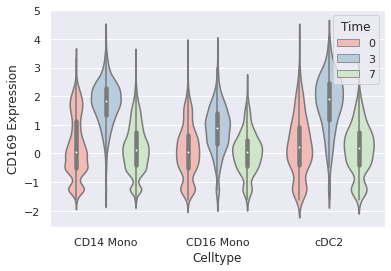

In [37]:
import seaborn as sns
from matplotlib import pyplot

sns.set(style="darkgrid")
 
# Grouped violinplot
sns.violinplot(x = "Celltype", y = "CD169 Expression", hue = "Time", data = df, palette = "Pastel1")
pyplot.show()

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


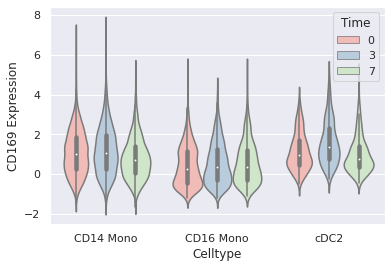

In [38]:
imputed_proteins_test.columns = var_data.index

df = extract_vector(imputed_proteins_test, meta_data, 'CD169')

sns.set(style="darkgrid")
 
# Grouped violinplot
sns.violinplot(x = "Celltype", y = "CD169 Expression", hue = "Time", data = df, palette = "Pastel1")
pyplot.show()

df.to_csv("totalvi_CD169.csv")

In [39]:
def get_groups(df, celltype):
    df_sub = df[df['Celltype'] == celltype]
    time0 = df_sub[df['Time'] == '0']
    time3 = df_sub[df['Time'] == '3']
    time7 = df_sub[df['Time'] == '7']
    
    return time0['CD169 Expression'], time3['CD169 Expression'], time7['CD169 Expression']

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
from scipy.stats import kruskal

kruskal(*get_groups(df, 'CD14 Mono'))

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


KruskalResult(statistic=402.7717270855526, pvalue=3.461232157983065e-88)

In [41]:
kruskal(*get_groups(df, 'CD16 Mono'))

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


KruskalResult(statistic=10.80757908810483, pvalue=0.0044994975497432985)

In [42]:
kruskal(*get_groups(df, 'cDC2'))

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


KruskalResult(statistic=81.40602608541076, pvalue=2.1033233284365685e-18)